Importing Libraries


In [1]:
import csv
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import norm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy import stats
from tabulate import tabulate

Loading Dataset


In [ ]:
fashion_mnist = fetch_openml(data_id=40996,as_frame=False,parser="auto")
fashion_mnist.data.shape

(70000, 784)

In [ ]:
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

Preprocessing Data

In [ ]:
X = fashion_mnist.data.astype('float32')
y = fashion_mnist.target.astype('int64')
# noise = np.random.normal(0, 0.1, X.shape)
# X_noise = X + noise
# noisy_array = np.clip(noisy_array, 0, 1)

In [ ]:
def plot_example(X, y,k=5):
    """Plot the first 5 images and their labels in a row."""
    plt.figure(figsize=(10,6))
    for i, (img, y) in enumerate(zip(X[:k].reshape(k, 28, 28), y[:k])):
        plt.subplot(1,k,1+i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

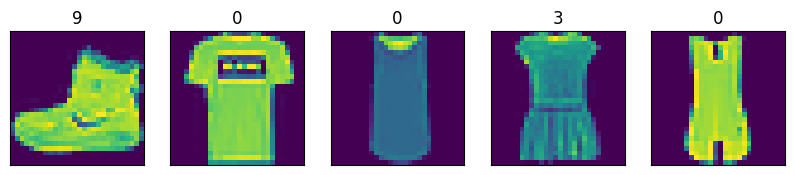

In [ ]:
plot_example(X, y)

Split Data

In [ ]:
X_splits = {}
y_splits = {}
unique_labels = np.unique(y)
for label in unique_labels:
    X_splits[label] = X[y == label]
    y_splits[label] = y[y == label]


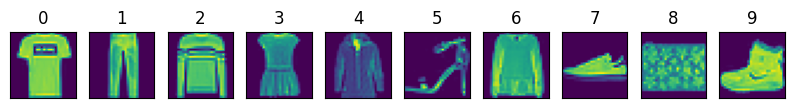

In [ ]:
sample_X = []
sample_y = []
for i in range(10):
    sample_X.append(X_splits[i][0])
    sample_y.append(y_splits[i][0])
sample_X = np.array(sample_X)
sample_y = np.array(sample_y)
plot_example(sample_X,sample_y,k=10)

In [ ]:
X_26 = np.concatenate((X_splits[2],X_splits[6]),axis=0)
y_26 = np.concatenate((y_splits[2],y_splits[6]))

In [ ]:
print(X_26.shape,y_26.shape)

(14000, 784) (14000,)


In [ ]:
y_26_oh = y_26.copy()
y_26_oh[y_26_oh == 2] = 1
y_26_oh[y_26_oh == 6] = 0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_26,y_26_oh, test_size=0.20, random_state=42,shuffle=True)

In [ ]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([5615, 5585]))

In [ ]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([1385, 1415]))

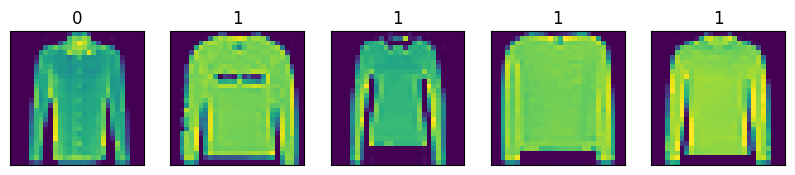

In [ ]:
plot_example(X_train, y_train)

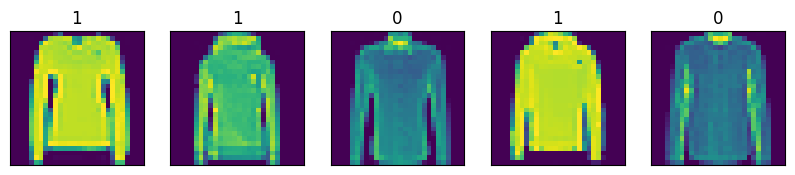

In [ ]:
plot_example(X_test, y_test)

In [ ]:

def write_to_csv(data,csv_file_path):
    # Check if the CSV file exists
    if os.path.exists(csv_file_path):
        # Read the existing data from the CSV file
        existing_data = pd.read_csv(csv_file_path, header=None).values.tolist()
    else:
        existing_data = []

    # Transpose the data to write it in columns
    data = [data]  # Convert data into a list of lists
    data = list(map(list, zip(*data)))  # Transpose the data

    # Append the new data to the existing data
    if existing_data:
        for i in range(min(len(existing_data), len(data))):
            existing_data[i].extend(data[i])
    else:
        existing_data = data

    # Write the combined data to the CSV file
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write the data to the CSV file column-wise
        for row in existing_data:
            writer.writerow(row)

In [ ]:
def sampling(n,input,output,replace=False):
    indices = np.random.choice(len(input),n,replace=replace)
    bootstrap_X = X_train[indices]
    bootstrap_y = y_train[indices]
    return bootstrap_X,bootstrap_y

def create_model():
    model = keras.Sequential()
    model.add(layers.Input(shape=(784,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_table(model,input,output):
    pred = model.predict(input)
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    # Calculate confusion matrix values
    for i in range(len(pred)):
        if output[i] == 1 and pred[i] == 1:
            true_positives += 1
        elif output[i] == 0 and pred[i] == 0:
            true_negatives += 1
        elif output[i] == 0 and pred[i] == 1:
            false_positives += 1
        elif output[i] == 1 and pred[i] == 0:
            false_negatives += 1

    # Create the confusion matrix as a list of lists
    confusion_matrix_result = [[true_negatives, false_positives],
                            [false_negatives, true_positives]]

    # Convert the confusion matrix to a numpy array for better visualization (optional)
    confusion_matrix_array = np.array(confusion_matrix_result)
    return confusion_matrix_array

def joint_odds_ratio(tables):
    k = len(tables)
    num = 0
    den = 0
    for i in range(k):
        sum = tables[i][0][0] + tables[i][0][1] + tables[i][1][1] + tables[i][1][0]
        num = num + (tables[i][0][0]*tables[i][1][1])/sum
        den = den + (tables[i][0][1]*tables[i][1][0])/sum
    return num/den

def odds_ratio(table):
    pA = table[0][0]/(table[0][0]+table[1][0])
    pB = table[0][1]/(table[0][1]+table[1][1])
    return (pA*(1-pB))/(pB*(1-pA))

In [ ]:
start_time = time.time()
k = 10
n = 5000
models = []
for i in range(k):
    model = create_model()
    models.append(model)
train_tables = []
test_tables = []
for i in range(k):
    sampled_X,sampled_y = sampling(n,X_train,y_train,replace=True)
    # with tf.device('/GPU:0'):
    models[i].fit(sampled_X, sampled_y, epochs=10, verbose = 0)

    train_tables.append(create_table(models[i],sampled_X,sampled_y))
    # print(train_tables[-1])
    test_tables.append(create_table(models[i],X_test,y_test))

# End timing
end_time = time.time()
print("Time taken : ", end_time-start_time)

88/88 [==============================] - 0s 2ms/step
Time taken :  66.09852695465088


In [ ]:
def calculate_difference(model1,model2,X_test):
    p1 = model1.predict(X_test)
    p2 = model2.predict(X_test)
    return np.sum(abs(p1-p2))/len(X_test)

In [ ]:
differences = np.zeros((k,k))
for i in range(k):
    for j in range(k):
        differences[i][j] = calculate_difference(models[i],models[j],X_test)

88/88 [==============================] - 0s 2ms/step


In [ ]:
table_data = []
headers = []
for i in range(k):
    row = [f"Model{i}"]
    row.extend(differences[i])
    table_data.append(row)
    headers.append(f"Model{i}")
print(tabulate(table_data, headers, tablefmt="grid"))

+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
|        |   Model0 |   Model1 |   Model2 |   Model3 |   Model4 |   Model5 |   Model6 |   Model7 |   Model8 |   Model9 |
+========+==========+==========+==========+==========+==========+==========+==========+==========+==========+==========+
| Model0 | 0        | 0.274458 | 0.159981 | 0.295576 | 0.201094 | 0.204127 | 0.23808  | 0.205287 | 0.262234 | 0.216084 |
+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Model1 | 0.274458 | 0        | 0.270156 | 0.147407 | 0.207536 | 0.168542 | 0.263382 | 0.189885 | 0.132433 | 0.159107 |
+--------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Model2 | 0.159981 | 0.270156 | 0        | 0.292011 | 0.204842 | 0.200873 | 0.21841  | 0.179159 | 0.261594 | 0.210157 |
+--------+----------+----------+

In [ ]:
def calculate_difference_2(model1,model2,X_test):
    p1 = model1.predict(X_test)
    p1[p1>=0.5] = 1
    p1[p1<0.5] = 0
    p2 = model2.predict(X_test)
    p2[p2>=0.5] = 1
    p2[p2<0.5] = 0
    return np.sum(abs(p1-p2))

In [ ]:
differences_2 = np.zeros((k,k))
for i in range(k):
    for j in range(k):
        differences_2[i][j] = calculate_difference_2(models[i],models[j],X_test)

88/88 [==============================] - 0s 2ms/step


In [ ]:
table_data = []
headers = []
for i in range(k):
    row = [f"Model{i+1}"]
    row.extend(differences_2[i])
    table_data.append(row)
    headers.append(f"Model{i+1}")
print(tabulate(table_data, headers, tablefmt="grid"))

+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+
|         |   Model1 |   Model2 |   Model3 |   Model4 |   Model5 |   Model6 |   Model7 |   Model8 |   Model9 |   Model10 |
+=========+==========+==========+==========+==========+==========+==========+==========+==========+==========+===========+
| Model1  |        0 |      765 |      427 |      817 |      550 |      556 |      615 |      591 |      727 |       589 |
+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+
| Model2  |      765 |        0 |      740 |      400 |      581 |      451 |      940 |      398 |      358 |       442 |
+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+
| Model3  |      427 |      740 |        0 |      796 |      567 |      547 |      632 |      574 |      710 |       582 |
+---------+-----

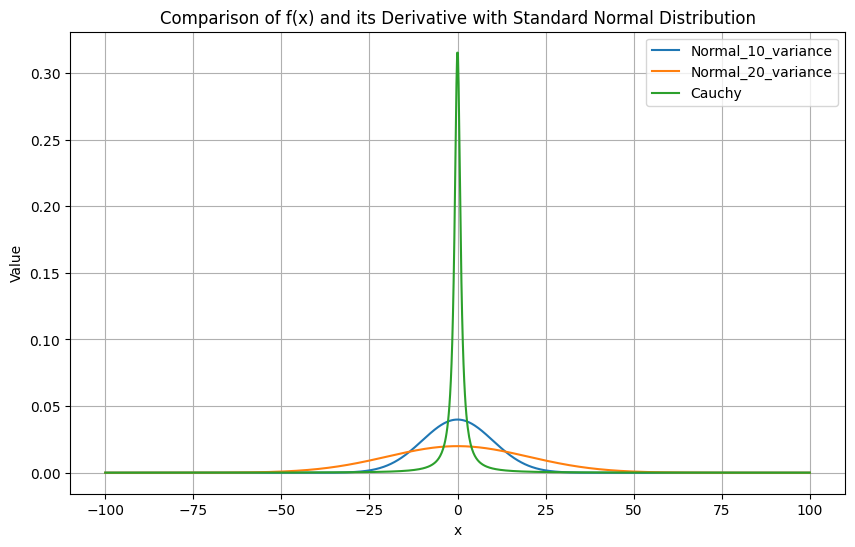

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function f(x)
def f(x):
    return (1 + np.tanh(x)) / 2

def cauchy(x):
    return 1 / (np.pi * (1 + x**2))
# Calculate the derivative of f(x)
def f_derivative(x):
    return 0.5 * (1 - np.tanh(x)**2)

# Generate a range of x values
x = np.linspace(-100, 100, 1000)

# Calculate f(x) and its derivative at each x value
y = f(x)
y_derivative = f_derivative(x)
cauchy_values = cauchy(x)

# Calculate the standard normal distribution (probability density function)
std_normal = 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)
var = 10
normal_10var = 1 / np.sqrt(2 * np.pi*var*var) * np.exp(-x**2 / (2*var*var))
var = 20
normal_20var = 1 / np.sqrt(2 * np.pi*var*var) * np.exp(-x**2 / (2*var*var))
# Create a plot to compare the two functions
plt.figure(figsize=(10, 6))
# plt.plot(x, y_derivative, label="derivative_tanh")
# plt.plot(x, std_normal, label='Standard Normal Distribution')
plt.plot(x, normal_10var, label='Normal_10_variance')
plt.plot(x, normal_20var, label='Normal_20_variance')
plt.plot(x, cauchy_values,label="Cauchy")
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison of f(x) and its Derivative with Standard Normal Distribution')
plt.grid()
plt.show()


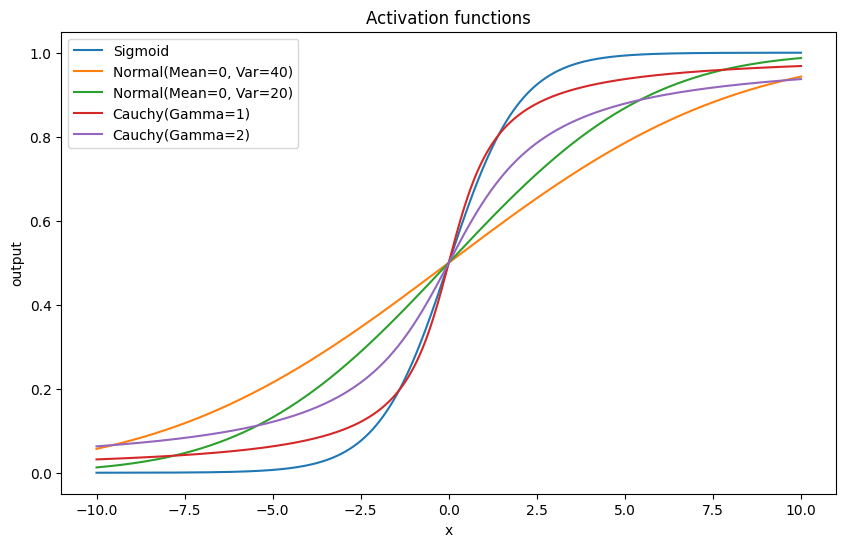

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy

# Generate data
x = np.linspace(-10, 10, 1000)

# Sigmoid function
sigmoid = 1 / (1 + np.exp(-x))

# CDF of normal distribution with variance=40
normal_cdf_var_40 = norm.cdf(x, scale=np.sqrt(40))

# CDF of normal distribution with variance=20
normal_cdf_var_20 = norm.cdf(x, scale=np.sqrt(20))

# CDF of Cauchy distribution with gamma=1
cauchy_cdf_gamma_1 = cauchy.cdf(x, scale=1)

# CDF of Cauchy distribution with gamma=2
cauchy_cdf_gamma_2 = cauchy.cdf(x, scale=2)

# Plot the graphs
plt.figure(figsize=(10, 6))
plt.plot(x, sigmoid, label='Sigmoid')
plt.plot(x, normal_cdf_var_40, label='Normal(Mean=0, Var=40)')
plt.plot(x, normal_cdf_var_20, label='Normal(Mean=0, Var=20)')
plt.plot(x, cauchy_cdf_gamma_1, label='Cauchy(Gamma=1)')
plt.plot(x, cauchy_cdf_gamma_2, label='Cauchy(Gamma=2)')

# Add labels and title
plt.xlabel('x')
plt.ylabel('output')
plt.title('Activation functions')
plt.legend()

# Show the plot
plt.show()


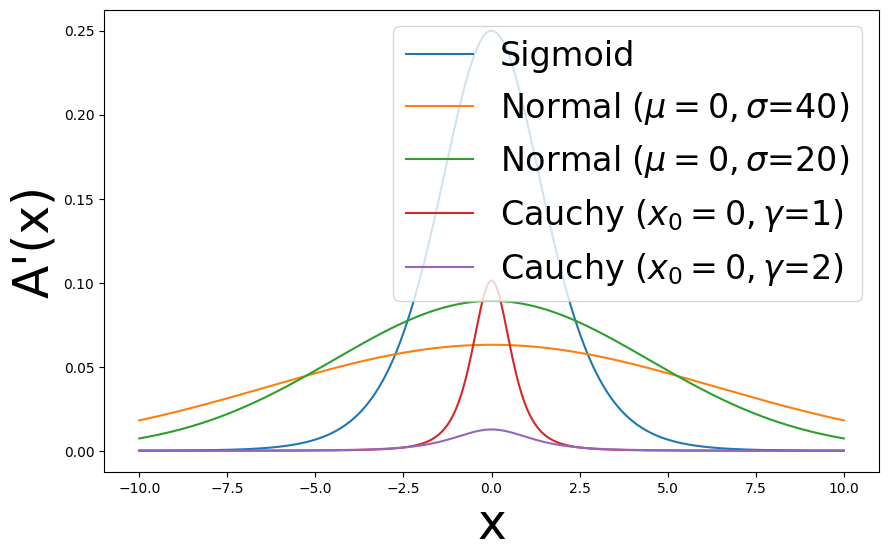

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy

# Generate data
x = np.linspace(-10, 10, 1000)

# Derivative of the sigmoid function
sigmoid_derivative = np.exp(-x) / (1 + np.exp(-x))**2

# PDF of normal distribution with variance=40
normal_pdf_var_40 = norm.pdf(x, scale=np.sqrt(40))

# PDF of normal distribution with variance=20
normal_pdf_var_20 = norm.pdf(x, scale=np.sqrt(20))

# PDF of Cauchy distribution with gamma=1
cauchy_pdf_gamma_1 = cauchy.pdf(x, scale=1) / np.pi / (1 + x**2)

# PDF of Cauchy distribution with gamma=2
cauchy_pdf_gamma_2 = cauchy.pdf(x, scale=2) / np.pi / (4 + x**2)

# Plot the derivatives
plt.figure(figsize=(10, 6))
plt.plot(x, sigmoid_derivative, label='Sigmoid')
plt.plot(x, normal_pdf_var_40, label='Normal ($\mu=0,\sigma$=40)')
plt.plot(x, normal_pdf_var_20, label='Normal ($\mu=0,\sigma$=20)')
plt.plot(x, cauchy_pdf_gamma_1, label='Cauchy ($x_{0}=0,\gamma$=1)')
plt.plot(x, cauchy_pdf_gamma_2, label='Cauchy ($x_{0}=0,\gamma$=2)')

# Add labels and title
plt.xlabel('x')
plt.ylabel("A'(x)")
plt.legend()

# Show the plot
plt.show()


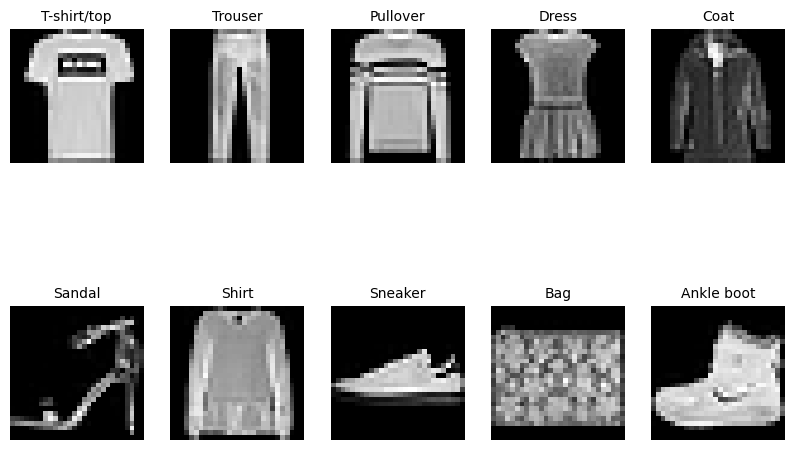

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset
(x_train, y_train), (_, _) = fashion_mnist.load_data()

# Define the labels for each category
class_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Create a 2x5 subplot grid
fig, axes = plt.subplots(2, 5, figsize=(10, 6))
fig.subplots_adjust(hspace=0.5)

# Iterate over each category and plot an image
for i, ax in enumerate(axes.flat):
    # Find the index of the first occurrence of the current label
    index = np.where(y_train == i)[0][0]
    # Display the image
    ax.imshow(x_train[index], cmap="gray")
    ax.axis("off")  # Turn off axis labels
    # Display the label below the image
    ax.set_title(class_labels[i], fontsize=10)

# Show the plot
plt.show()


In [2]:
different_train_csv_file_path = "/content/drive/MyDrive/Fashion MNIST/Fashion_MNIST_Train_Odds_Ratio_with_different_activations.csv"
different_test_csv_file_path = "/content/drive/MyDrive/Fashion MNIST/Fashion_MNIST_Test_Odds_Ratio_with_different_activations.csv"


In [3]:
different_train_df = pd.read_csv(different_train_csv_file_path)
different_test_df = pd.read_csv(different_test_csv_file_path)
different_ensemble_odds_ratio_train = different_train_df.values.ravel().tolist()
different_ensemble_odds_ratio_test = different_test_df.values.ravel().tolist()
different_ensemble_odds_ratio_train += [float(value) for value in different_train_df.columns.values.tolist()]
different_ensemble_odds_ratio_test += [float(value) for value in different_test_df.columns.values.tolist()]

FileNotFoundError: ignored

In [ ]:

train_csv_file_path = "/content/drive/MyDrive/Fashion MNIST/Fashion_MNIST_Train_Odds_Ratio.csv"
test_csv_file_path = "/content/drive/MyDrive/Fashion MNIST/Fashion_MNIST_Test_Odds_Ratio.csv"

In [4]:
train_df = pd.read_csv(train_csv_file_path)
test_df = pd.read_csv(test_csv_file_path)
ensemble_odds_ratio_train = train_df.values.ravel().tolist()
ensemble_odds_ratio_test = test_df.values.ravel().tolist()
ensemble_odds_ratio_train += [float(value) for value in train_df.columns.values.tolist()]
ensemble_odds_ratio_test += [float(value) for value in test_df.columns.values.tolist()]

NameError: ignored

In [ ]:
ks_statistic, p_value = ks_2samp(ensemble_odds_ratio_train,different_ensemble_odds_ratio_train)

In [5]:
ks_statistic

NameError: ignored

In [ ]:
p_value

In [6]:
ks_statistic, p_value = ks_2samp(ensemble_odds_ratio_test,different_ensemble_odds_ratio_test)

NameError: ignored

In [ ]:
ks_statistic

In [ ]:
p_value